# Описание проекта. Промышленность

Цель работы: На основании измеряемых данных, собранных на различных этапах технологического цикла выплавки металла, подобрать и обучить модель для предсказания температуры сплава.

План работы:
1) Загрузка требуемых данных
2) Анализ и обработка данных
3) Формирование консолидированного датасета и разделение его на тренировочную и тестовую части
4) Подбор и обучение различных моделей
5) Тестирование оптимальной модели на отложенной выборке
6) Определение наиболее значимых показателей для предсказания целевого признака
7) Вывод по итогам работы

Описание данных
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
steel.data_arc — данные об электродах;
steel.data_bulk — данные об объёме сыпучих материалов;
steel.data_bulk_time — данные о времени подачи сыпучих материалов;
steel.data_gas — данные о продувке сплава газом;
steel.data_temp — данные об измерениях температуры;
steel.data_wire — данные об объёме проволочных материалов;
steel.data_wire_time — данные о времени подачи проволочных материалов.
Таблица steel.data_arc
key — номер партии;
BeginHeat — время начала нагрева;
EndHeat — время окончания нагрева;
ActivePower — значение активной мощности;
ReactivePower — значение реактивной мощности.
Таблица steel.data_bulk
key — номер партии;
Bulk1 … Bulk15 — объём подаваемого материала.
Таблица steel.data_bulk_time
key — номер партии;
Bulk1 … Bulk15 — время подачи материала.
Таблица steel.data_gas
key — номер партии;
gas — объём подаваемого газа.
Таблица steel.data_temp
key — номер партии;
MesaureTime — время замера;
Temperature — значение температуры.
Таблица steel.data_wire
key — номер партии;
Wire1 … Wire15 — объём подаваемых проволочных материалов.
Таблица steel.data_wire_time
key — номер партии;
Wire1 … Wire15 — время подачи проволочных материалов.
Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime, date, time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     GlobalAveragePooling2D,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization)
from tensorflow.keras.optimizers import Adam

%matplotlib inline


In [2]:
RANDOM_STATE = 201123

## Загрузка данных

In [3]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'steel';
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [6]:
sample_df

,table_name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_gas
4,data_temp
5,data_wire
6,data_wire_time


In [7]:
query = '''
SELECT *
FROM steel.data_arc
LIMIT 10;
'''

data_arc = pd.read_sql_query(query, con=engine) 

In [8]:
data_arc

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
5,2,11:34:14,11:36:31,0.438063,0.283043
6,2,11:38:50,11:44:28,1.296415,0.892914
7,2,11:46:19,11:48:25,0.490377,0.305281
8,2,11:49:48,11:53:18,0.827743,0.516874
9,3,12:06:54,12:11:34,1.062053,0.671494


In [9]:
query = '''
SELECT *
FROM steel.data_bulk
LIMIT 10;
'''

data_bulk = pd.read_sql_query(query, con=engine) 

In [10]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,None,None,None,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,None,None,None,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,None,None,None,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


In [11]:
query = '''
SELECT *
FROM steel.data_bulk_time
LIMIT 10;
'''

data_bulk_time = pd.read_sql_query(query, con=engine) 

In [12]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
5,6,None,None,None,13:59:24,None,None,None,None,None,None,None,13:53:27,None,13:53:27,13:53:27
6,7,None,None,None,14:29:14,None,None,None,None,None,None,None,14:22:19,None,14:22:19,14:22:19
7,8,None,None,None,15:04:05,None,None,None,None,None,None,None,14:55:46,None,14:55:46,14:55:46
8,9,None,None,None,15:47:34,None,None,None,None,None,None,None,15:41:00,None,15:41:00,15:41:00
9,10,None,None,None,None,None,None,None,None,None,None,None,16:18:52,None,16:18:52,16:18:52


In [13]:
query = '''
SELECT *
FROM steel.data_gas
LIMIT 10;
'''

data_gas = pd.read_sql_query(query, con=engine) 

In [14]:
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [15]:
query = '''
SELECT *
FROM steel.data_temp
LIMIT 10;
'''

data_temp = pd.read_sql_query(query, con=engine) 

In [16]:
data_temp

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
5,2,11:37:27,1581.0
6,2,11:38:00,1577.0
7,2,11:49:38,1589.0
8,2,11:55:50,1604.0
9,2,11:58:24,1608.0


In [17]:
query = '''
SELECT *
FROM steel.data_wire
LIMIT 10;
'''

data_wire = pd.read_sql_query(query, con=engine) 

In [18]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,None,None,None,None,None,None,None
1,2,96.052315,NaN,None,None,None,None,None,None,None
2,3,91.160157,NaN,None,None,None,None,None,None,None
3,4,89.063515,NaN,None,None,None,None,None,None,None
4,5,89.238236,9.114560,None,None,None,None,None,None,None
5,6,99.109917,9.114560,None,None,None,None,None,None,None
6,7,98.061600,NaN,None,None,None,None,None,None,None
7,8,155.282394,NaN,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376000,None,None,None,None,None,None,None


In [19]:
query = '''
SELECT *
FROM steel.data_wire_time
LIMIT 10;
'''

data_wire_time = pd.read_sql_query(query, con=engine) 

In [20]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
5,6,13:59:02,13:59:54,None,None,None,None,None,None,None
6,7,14:28:46,None,None,None,None,None,None,None,None
7,8,15:03:42,None,None,None,None,None,None,None,None
8,9,15:42:43,15:58:12,None,None,None,None,None,None,None
9,10,16:20:25,16:21:02,None,None,None,None,None,None,None


## Предварительный вывод №1

В качестве данных для обучения и тестирования моделей представлены 7 таблиц, данные в них соответствуют техническому заданию.

# Анализ и обработка данных

## работа с data_arc 

In [21]:
query = '''
SELECT *
FROM steel.data_arc;
'''

data_arc = pd.read_sql_query(query, con=engine) 

In [22]:
data_arc.head(3)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805


In [23]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [24]:
data_arc.describe()

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


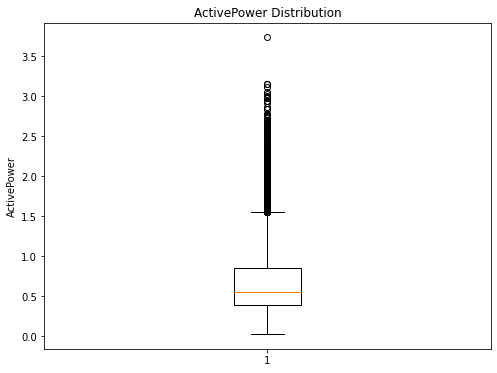

In [25]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_arc['ActivePower'])
plt.title('ActivePower Distribution')
plt.ylabel('ActivePower')
plt.show()

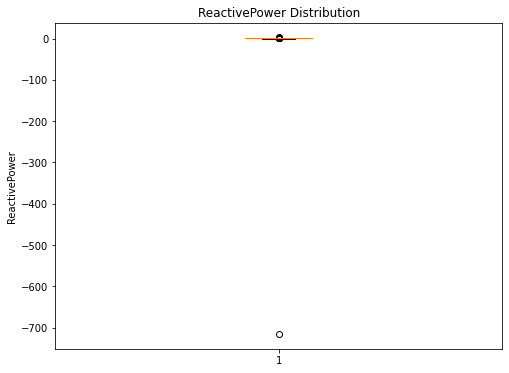

In [26]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_arc['ReactivePower'])
plt.title('ReactivePower Distribution')
plt.ylabel('ReactivePower')
plt.show()

In [27]:
data_arc.duplicated().sum()

0

In [28]:
data_arc.isna().sum()

key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64

In [29]:
data_arc = data_arc[data_arc['ReactivePower'] >= 0]


Строка с аномальным значение в столбце 'ReactivePower' (-715.504924) удалена

In [30]:
data_arc.describe()

,key,ActivePower,ReactivePower
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


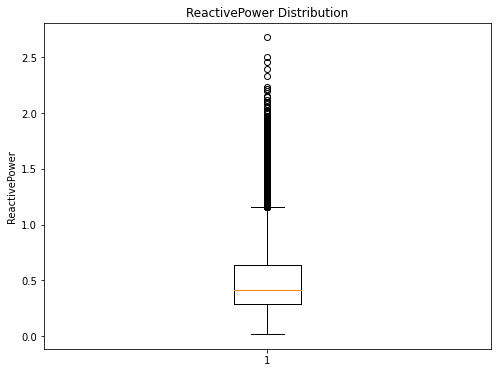

In [31]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_arc['ReactivePower'])
plt.title('ReactivePower Distribution')
plt.ylabel('ReactivePower')
plt.show()

In [32]:
data_arc['TotalPower'] = data_arc['ActivePower'] + data_arc['ReactivePower'] 

По логике технологического процесса, ActivePower - расчётная величина энергии, затраченной на нагрев сплава. ReactivePower - энергия, тратящаяся на нагрев котла, непосредственно нагревательных элементов, в дальнейшем это тепло может уходить в этот же сплав, окружающий воздух и пр. 
Я посчитал, что генерация нового признака - общая затраченная энергия, принесёт пользу для обучения модели. 

In [33]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14875 non-null  int64  
 1   BeginHeat      14875 non-null  object 
 2   EndHeat        14875 non-null  object 
 3   ActivePower    14875 non-null  float64
 4   ReactivePower  14875 non-null  float64
 5   TotalPower     14875 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 813.5+ KB


In [34]:
data_arc

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,TotalPower
0,1,11:02:14,11:06:02,0.976059,0.687084,1.663142
1,1,11:07:28,11:10:33,0.805607,0.520285,1.325892
2,1,11:11:44,11:14:36,0.744363,0.498805,1.243169
3,1,11:18:14,11:24:19,1.659363,1.062669,2.722032
4,1,11:26:09,11:28:37,0.692755,0.414397,1.107152
...,...,...,...,...,...,...
14871,3241,03:58:58,04:01:35,0.533670,0.354439,0.888108
14872,3241,04:05:04,04:08:04,0.676604,0.523631,1.200235
14873,3241,04:16:41,04:19:45,0.733899,0.475654,1.209553
14874,3241,04:31:51,04:32:48,0.220694,0.145768,0.366462


In [35]:
data_arc = data_arc.drop({'BeginHeat', 'EndHeat'}, axis=1)
# Удаляем временные метки, для дальнейшего анализа они не нужны

In [36]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14875 non-null  int64  
 1   ActivePower    14875 non-null  float64
 2   ReactivePower  14875 non-null  float64
 3   TotalPower     14875 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 581.1 KB


In [37]:
indexed_df = data_arc.set_index(['key', data_arc.groupby('key').cumcount() + 1])

data_arc = indexed_df.unstack()
#формируем таблицу, где одно наблюдение - это одна партия металла

In [38]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (ActivePower, 1)     3214 non-null   float64
 1   (ActivePower, 2)     3175 non-null   float64
 2   (ActivePower, 3)     3001 non-null   float64
 3   (ActivePower, 4)     2480 non-null   float64
 4   (ActivePower, 5)     1589 non-null   float64
 5   (ActivePower, 6)     830 non-null    float64
 6   (ActivePower, 7)     340 non-null    float64
 7   (ActivePower, 8)     135 non-null    float64
 8   (ActivePower, 9)     51 non-null     float64
 9   (ActivePower, 10)    23 non-null     float64
 10  (ActivePower, 11)    14 non-null     float64
 11  (ActivePower, 12)    9 non-null      float64
 12  (ActivePower, 13)    6 non-null      float64
 13  (ActivePower, 14)    4 non-null      float64
 14  (ActivePower, 15)    3 non-null      float64
 15  (ActivePower, 16)    1 non-null      f

In [39]:
data_arc.head()

ActivePower                                                              \
             1         2         3         4         5   6   7   8   9   10   
key                                                                           
1      0.976059  0.805607  0.744363  1.659363  0.692755 NaN NaN NaN NaN NaN   
2      0.438063  1.296415  0.490377  0.827743       NaN NaN NaN NaN NaN NaN   
3      1.062053  0.484206  0.429355  0.299989  0.250280 NaN NaN NaN NaN NaN   
4      0.875313  0.425692  0.687289  1.220955       NaN NaN NaN NaN NaN NaN   
5      0.950026  0.508026  1.621665  0.267457       NaN NaN NaN NaN NaN NaN   

     ... TotalPower                                      
     ...         7   8   9   10  11  12  13  14  15  16  
key  ...                                                 
1    ...        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2    ...        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3    ...        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4    ...        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
5    ...        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 48 columns]

In [40]:
data_arc = data_arc.fillna(0)

In [41]:
data_arc.describe()

ActivePower                                                      \
                1            2            3            4            5    
count  3214.000000  3214.000000  3214.000000  3214.000000  3214.000000   
mean      0.546455     0.925447     0.675164     0.485703     0.257030   
std       0.258149     0.513689     0.417803     0.412320     0.342539   
min       0.035165     0.000000     0.000000     0.000000     0.000000   
25%       0.414998     0.565929     0.364363     0.154113     0.000000   
50%       0.476031     0.841619     0.653067     0.441157     0.000000   
75%       0.581292     1.200291     0.914685     0.741021     0.438212   
max       2.940772     3.156276     2.943082     2.642402     2.837007   

                                                                        ...  \
                6            7            8            9            10  ...   
count  3214.000000  3214.000000  3214.000000  3214.000000  3214.000000  ...   
mean      0.124504     0.048506     0.020745     0.008759     0.004245  ...   
std       0.252335     0.175594     0.125133     0.092816     0.059780  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.144037     0.000000     0.000000     0.000000     0.000000  ...   
max       2.258434     3.731596     2.864100     2.643099     1.786526  ...   

        TotalPower                                                      \
                7            8            9            10           11   
count  3214.000000  3214.000000  3214.000000  3214.000000  3214.000000   
mean      0.083981     0.035896     0.015559     0.007385     0.005136   
std       0.303931     0.217064     0.165802     0.103119     0.098055   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       6.407984     5.014758     4.467032     2.903004     3.116809   

                                                                        
                12           13           14           15           16  
count  3214.000000  3214.000000  3214.000000  3214.000000  3214.000000  
mean      0.002468     0.002041     0.001149     0.000760     0.000226  
std       0.055042     0.068144     0.043210     0.025675     0.012836  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.910152     3.459094     2.270565     1.080425     0.727694  

[8 rows x 48 columns]

In [42]:
# Выбираем колонки, где минимальное значение меньше 0
#cols_with_neg_min = data_arc.columns[(data_arc.min() < 0)].tolist()

# Выводим названия выбранных колонок
#print("Колонки, где минимальное значение меньше 0:")
#print(cols_with_neg_min)

Колонки, где минимальное значение меньше 0:
[('ContHeat', 1), ('ContHeat', 2), ('ContHeat', 3), ('ContHeat', 4), ('ContHeat', 5), ('ContHeat', 6), ('ContHeat', 8), ('IntHeat', 1), ('IntHeat', 2), ('IntHeat', 3), ('IntHeat', 4), ('IntHeat', 5), ('IntHeat', 6), ('IntHeat', 8)]

При анализе сформированных признаков: продолжительность и интенсивность нагрева где используются временные показатели, выявлены ошибки времени, которые приводят к отрицательным значениям этих признаков. В связи с этим от этих признаков решено воздержаться

### В таблице нагревания металла представлены данные о 14875 сеансов нагрева 3214 партий металла. Дубликатов наблюдений не выявлено, аномалии исправлены. Сформирован новый признак: общая затраченная энергия. Выполнена группировка таблицы по номеру партии.

## работа с data_bulk

In [43]:
query = '''
SELECT *
FROM steel.data_bulk;
'''

data_bulk = pd.read_sql_query(query, con=engine) 

In [44]:
data_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [45]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [46]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [47]:
data_bulk = data_bulk.fillna(0)

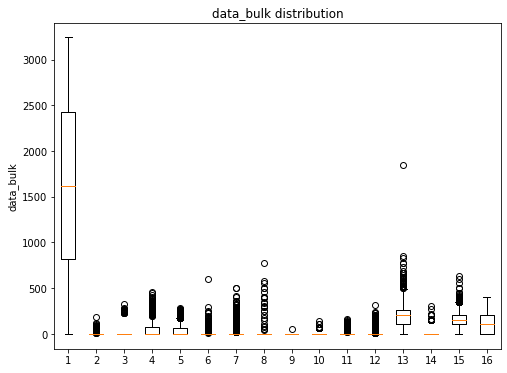

In [48]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_bulk)
plt.title('data_bulk distribution')
plt.ylabel('data_bulk')
plt.show()

В каждую партию металла засыпаются сыпучие компоненты сплава, масса которых отражена в этой таблице. Добавление их происходит не единомоментно, а в определённый момент технологического цикла. Исходя из этой таблицы, моментов для засыпки материалов - 15 на каждую партию. Массы материалов засыпаемые в каждую партию в определённый момент разные. Материалы засыпались не в каждый из технологических моментов для этого (в момент Bulk 8 только одна партия металла из 3129 получила свою порцию). Таким образом, пропуски в этой таблице заменяем на ноль, тем самым отражаем, что сам момент добавки был, но материал добавлен не был. 
Такая же логика в обработке пропусков и в таблице data_wire.

### В таблице представлены данные о добавлении сыпучих компонентов в партию металла. Собраны данные о 3129 партий. Засыпка происходит порциями в течении времени плавки (максимум 15 порций на партию)

## работа с data_bulk_time

In [49]:
query = '''
SELECT *
FROM steel.data_bulk_time;
'''

data_bulk_time = pd.read_sql_query(query, con=engine) 

In [50]:
data_bulk_time.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40


In [51]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [52]:
key_column = data_bulk_time['key']
data_bulk_time = data_bulk_time.drop('key', axis=1)
data_bulk_time = data_bulk_time.replace('None', np.nan)
data_bulk_time = data_bulk_time.apply(pd.to_datetime, format='%H:%M:%S', errors='coerce')
data_bulk_time['key'] = key_column

In [53]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
 15  key      3129 non-null   int64         
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [54]:
data_bulk_time.head(3)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,key
0,NaT,NaT,NaT,1900-01-01 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:03:52,NaT,1900-01-01 11:03:52,1900-01-01 11:03:52,1
1,NaT,NaT,NaT,1900-01-01 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:40:20,NaT,1900-01-01 11:40:20,1900-01-01 11:40:20,2
2,NaT,NaT,NaT,1900-01-01 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:09:40,NaT,1900-01-01 12:09:40,1900-01-01 12:09:40,3


In [55]:
# Найдем минимум и максимум для каждого столбца
min_values = data_bulk_time.min()
max_values = data_bulk_time.max()

# Отобразим результат
print("Минимум для каждого столбца:")
print(min_values)
print("\nМаксимум для каждого столбца:")
print(max_values)

Минимум для каждого столбца:
Bulk 1     1900-01-01 00:00:13
Bulk 2     1900-01-01 08:36:19
Bulk 3     1900-01-01 00:00:01
Bulk 4     1900-01-01 00:00:38
Bulk 5     1900-01-01 00:01:33
Bulk 6     1900-01-01 00:01:25
Bulk 7     1900-01-01 00:42:38
Bulk 8     1900-01-01 17:46:11
Bulk 9     1900-01-01 00:04:56
Bulk 10    1900-01-01 00:01:01
Bulk 11    1900-01-01 00:28:29
Bulk 12    1900-01-01 00:01:00
Bulk 13    1900-01-01 00:39:35
Bulk 14    1900-01-01 00:00:11
Bulk 15    1900-01-01 00:01:00
key                          1
dtype: object

Максимум для каждого столбца:
Bulk 1     1900-01-01 23:54:24
Bulk 2     1900-01-01 18:01:50
Bulk 3     1900-01-01 23:57:32
Bulk 4     1900-01-01 23:59:30
Bulk 5     1900-01-01 23:42:34
Bulk 6     1900-01-01 23:56:15
Bulk 7     1900-01-01 18:01:50
Bulk 8     1900-01-01 17:46:11
Bulk 9     1900-01-01 18:58:01
Bulk 10    1900-01-01 23:32:50
Bulk 11    1900-01-01 23:56:15
Bulk 12    1900-01-01 23:58:54
Bulk 13    1900-01-01 23:34:05
Bulk 14    1900-01-01 23:58

### Данные о времени добавления порций сыпучих компонентов сплава. С учётом поставленной задачи и условий задания эти данные не потребуются.

## работа с data_gas

In [56]:
query = '''
SELECT *
FROM steel.data_gas;
'''

data_gas = pd.read_sql_query(query, con=engine) 

In [57]:
data_gas.head(3)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [58]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [59]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


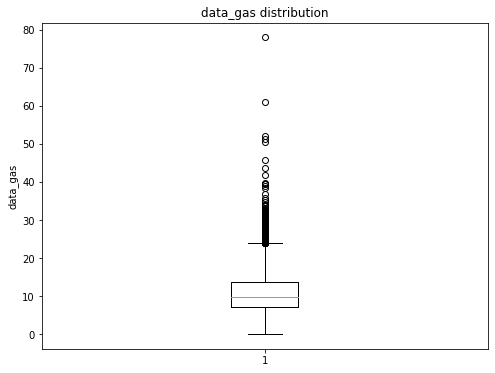

In [60]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_gas['gas'])
plt.title('data_gas distribution')
plt.ylabel('data_gas')
plt.show()

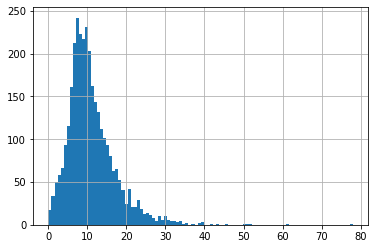

In [61]:
data_gas['gas'].hist(bins=100);

Есть 2 аномальных значения: 60 и 78. Заказчик не указывает, какие показатели заведомо ошибки измерения, поэтому считаем, что эти выбросы - технологическая необходимость и оставляем их. 

In [62]:
data_gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [63]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


### В таблице данные об объёме подаваемого газа при  выплавке партии металла. Данные о 3239 партиях.

## работа с data_temp

In [64]:
query = '''
SELECT *
FROM steel.data_temp;
'''

data_temp = pd.read_sql_query(query, con=engine) 

In [65]:
data_temp.head(3)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0


In [66]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [67]:
data_temp.describe()

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


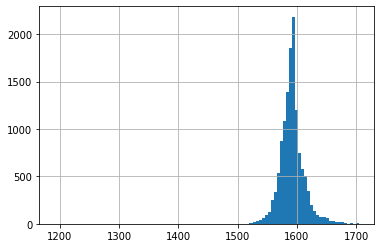

In [68]:
data_temp['Temperature'].hist(bins=100);

In [69]:
data_temp = data_temp[data_temp['Temperature'] >= 1500]

In [70]:
data_temp.describe()

,key,Temperature
count,12999.000000,12999.000000
mean,1328.243942,1592.020078
std,804.821269,19.853665
min,1.000000,1519.000000
25%,638.000000,1581.000000
50%,1315.000000,1591.000000
75%,1977.500000,1601.000000
max,3241.000000,1705.000000


In [71]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          12999 non-null  int64  
 1   MesaureTime  12999 non-null  object 
 2   Temperature  12999 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.2+ KB


In [72]:
# Создаем новый столбец, содержащий количество измерений температуры для каждой партии
data_temp['MeasurementCount'] = data_temp.groupby('key')['MesaureTime'].transform('count')

# Отбираем данные, где количество измерений больше или равно 2
filtered_data_temp = data_temp[data_temp['MeasurementCount'] >= 2].copy()

# Удаляем временный столбец
filtered_data_temp.drop(columns='MeasurementCount', inplace=True)


In [73]:
filtered_data_temp

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
...,...,...,...
12262,2498,02:19:26,1593.0
12263,2498,02:25:31,1594.0
12264,2499,02:40:25,1569.0
12265,2499,02:54:24,1604.0


In [74]:
filtered_data_temp.sort_values(by=['key', 'MesaureTime'], inplace=True)

first_temp = filtered_data_temp.groupby('key')['Temperature'].first().reset_index()
last_temp = filtered_data_temp.groupby('key')['Temperature'].last().reset_index()

# Переименование столбцов для последующего объединения
first_temp.columns = ['key', 'FirstTemperature']
last_temp.columns = ['key', 'LastTemperature']

# Объединение данных в новый DataFrame
data_temp_fin = pd.merge(first_temp, last_temp, on='key')




Формируем новый признак - последняя измеренная температура партии металла. у чассти партий металла в данных есть только одна измеренная температура - она будет входящим признаком, но целевым признаков для модели будет последняя измеренная температура партии.


In [75]:
data_temp_fin.head(15)

,key,FirstTemperature,LastTemperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


In [76]:
data_temp_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2475 non-null   int64  
 1   FirstTemperature  2475 non-null   float64
 2   LastTemperature   2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


Формируем таблицу из входящей и последней измеренной температур для каждой партии.

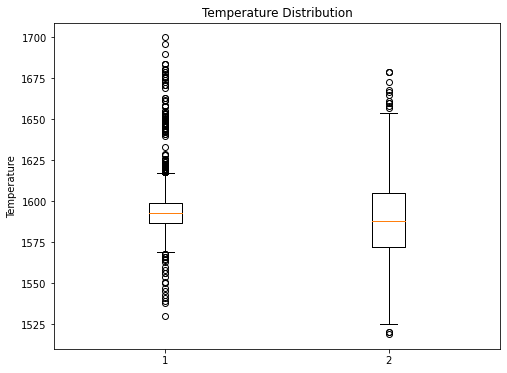

In [77]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_temp_fin[['LastTemperature', 'FirstTemperature']])
plt.title('Temperature Distribution')
plt.ylabel('Temperature')
plt.show()

### В таблице об измерениях температуры каждой партии металла 12999 наблюдений для 3241 партий. Из них только у 2475 партий есть как минимум 2 измерения (их мы оставляем как содержащие целевой признак)

## работа с data_wire

In [78]:
query = '''
SELECT *
FROM steel.data_wire;
'''

data_wire = pd.read_sql_query(query, con=engine) 

In [79]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [80]:
data_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
data_wire = data_wire.fillna(0)

In [82]:
data_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


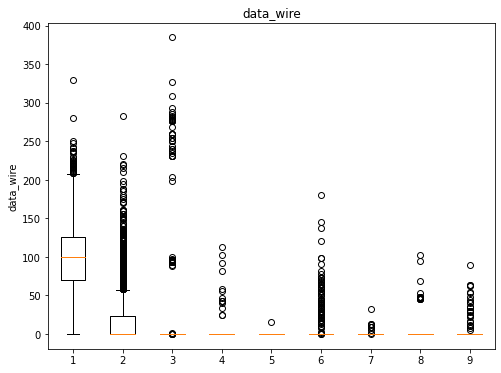

In [83]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_wire[['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']])
plt.title('data_wire')
plt.ylabel('data_wire')
plt.show()

### Таблица содержит данные об объёме подаваемых проволочных материалов для каждой партии металла. Материалы подаются порциями (максимально 9 порций), в большинстве случаев закладка проволочных материалов прводилась в первую порцию. При обработке датасета пропуски заменены на 0

## работа с data_wire_time

In [84]:
query = '''
SELECT *
FROM steel.data_wire_time;
'''

data_wire_time = pd.read_sql_query(query, con=engine) 

In [85]:
data_wire_time.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None


In [86]:
key_column = data_wire_time['key']
data_wire_time = data_wire_time.drop('key', axis=1)
data_wire_time = data_wire_time.replace('None', np.nan)
data_wire_time = data_wire_time.apply(pd.to_datetime, format='%H:%M:%S', errors='coerce')
data_wire_time['key'] = key_column

In [87]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wire 3  63 non-null     datetime64[ns]
 3   Wire 4  14 non-null     datetime64[ns]
 4   Wire 5  1 non-null      datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
 9   key     3081 non-null   int64         
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [88]:
data_wire_time.head(3)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,key
0,1900-01-01 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1
1,1900-01-01 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2
2,1900-01-01 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,3


In [89]:
# Найдем минимум и максимум для каждого столбца
min_values = data_wire_time.min()
max_values = data_wire_time.max()

# Отобразим результат
print("Минимум для каждого столбца:")
print(min_values)
print("\nМаксимум для каждого столбца:")
print(max_values)

Минимум для каждого столбца:
Wire 1    1900-01-01 00:00:37
Wire 2    1900-01-01 00:01:56
Wire 3    1900-01-01 01:29:02
Wire 4    1900-01-01 07:15:28
Wire 5    1900-01-01 16:01:07
Wire 6    1900-01-01 00:04:33
Wire 7    1900-01-01 10:01:56
Wire 8    1900-01-01 00:03:32
Wire 9    1900-01-01 00:21:11
key                         1
dtype: object

Максимум для каждого столбца:
Wire 1    1900-01-01 23:59:55
Wire 2    1900-01-01 23:58:54
Wire 3    1900-01-01 23:27:46
Wire 4    1900-01-01 18:09:32
Wire 5    1900-01-01 16:01:07
Wire 6    1900-01-01 23:47:40
Wire 7    1900-01-01 19:46:16
Wire 8    1900-01-01 18:58:07
Wire 9    1900-01-01 23:59:16
key                      3241
dtype: object


### Данные о времени подачи проволочных материалов в сплав для каждой партии металла в течении 1 суток. С учётом поставленной задачи и условий задания эти данные не потребуются.

## Формирование единого датасета

In [90]:
data_all = pd.merge(data_temp_fin, data_gas, on='key', how='inner')

In [91]:
data_all = pd.merge(data_all, data_arc, on='key', how='inner')

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [92]:
data_all = pd.merge(data_all, data_bulk, on='key', how='inner')

In [93]:
data_all = pd.merge(data_all, data_wire, on='key', how='inner')

In [94]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 76 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2329 non-null   int64  
 1   FirstTemperature     2329 non-null   float64
 2   LastTemperature      2329 non-null   float64
 3   gas                  2329 non-null   float64
 4   (ActivePower, 1)     2329 non-null   float64
 5   (ActivePower, 2)     2329 non-null   float64
 6   (ActivePower, 3)     2329 non-null   float64
 7   (ActivePower, 4)     2329 non-null   float64
 8   (ActivePower, 5)     2329 non-null   float64
 9   (ActivePower, 6)     2329 non-null   float64
 10  (ActivePower, 7)     2329 non-null   float64
 11  (ActivePower, 8)     2329 non-null   float64
 12  (ActivePower, 9)     2329 non-null   float64
 13  (ActivePower, 10)    2329 non-null   float64
 14  (ActivePower, 11)    2329 non-null   float64
 15  (ActivePower, 12)    2329 non-null   f

In [95]:
data_all.head()

,key,FirstTemperature,LastTemperature,gas,"(ActivePower, 1)","(ActivePower, 2)","(ActivePower, 3)","(ActivePower, 4)","(ActivePower, 5)","(ActivePower, 6)",...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,29.749986,0.976059,0.805607,0.744363,1.659363,0.692755,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,12.555561,0.438063,1.296415,0.490377,0.827743,0.000000,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,28.554793,1.062053,0.484206,0.429355,0.299989,0.250280,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,18.841219,0.875313,0.425692,0.687289,1.220955,0.000000,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,5.413692,0.950026,0.508026,1.621665,0.267457,0.000000,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
data_all.describe()

,key,FirstTemperature,LastTemperature,gas,"(ActivePower, 1)","(ActivePower, 2)","(ActivePower, 3)","(ActivePower, 4)","(ActivePower, 5)","(ActivePower, 6)",...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1587.324603,1593.157578,11.375600,0.559511,0.915950,0.677757,0.495746,0.274203,0.132263,...,119.952769,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,714.762400,23.484975,11.457211,6.392041,0.273767,0.492876,0.410764,0.407516,0.352565,0.259108,...,84.640443,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,1.000000,1519.000000,1530.000000,0.008399,0.035165,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,630.000000,1571.000000,1587.000000,7.282948,0.418077,0.569849,0.373708,0.198136,0.000000,0.000000,...,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,1587.000000,1593.000000,10.100950,0.481270,0.843949,0.655212,0.448204,0.141432,0.000000,...,107.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,1603.000000,1598.000000,14.216688,0.594321,1.192975,0.912510,0.744472,0.468527,0.196153,...,204.000000,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,77.995040,2.940772,3.156276,2.943082,2.642402,2.837007,2.258434,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'FirstTemperature'}>,
        <AxesSubplot:title={'center':'LastTemperature'}>,
        <AxesSubplot:title={'center':'gas'}>,
        <AxesSubplot:title={'center':"('ActivePower', 1)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 2)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 3)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 4)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 5)"}>],
       [<AxesSubplot:title={'center':"('ActivePower', 6)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 7)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 8)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 9)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 10)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 11)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 12)"}>,
        <AxesSubplot:title={'center':"('ActivePower', 1

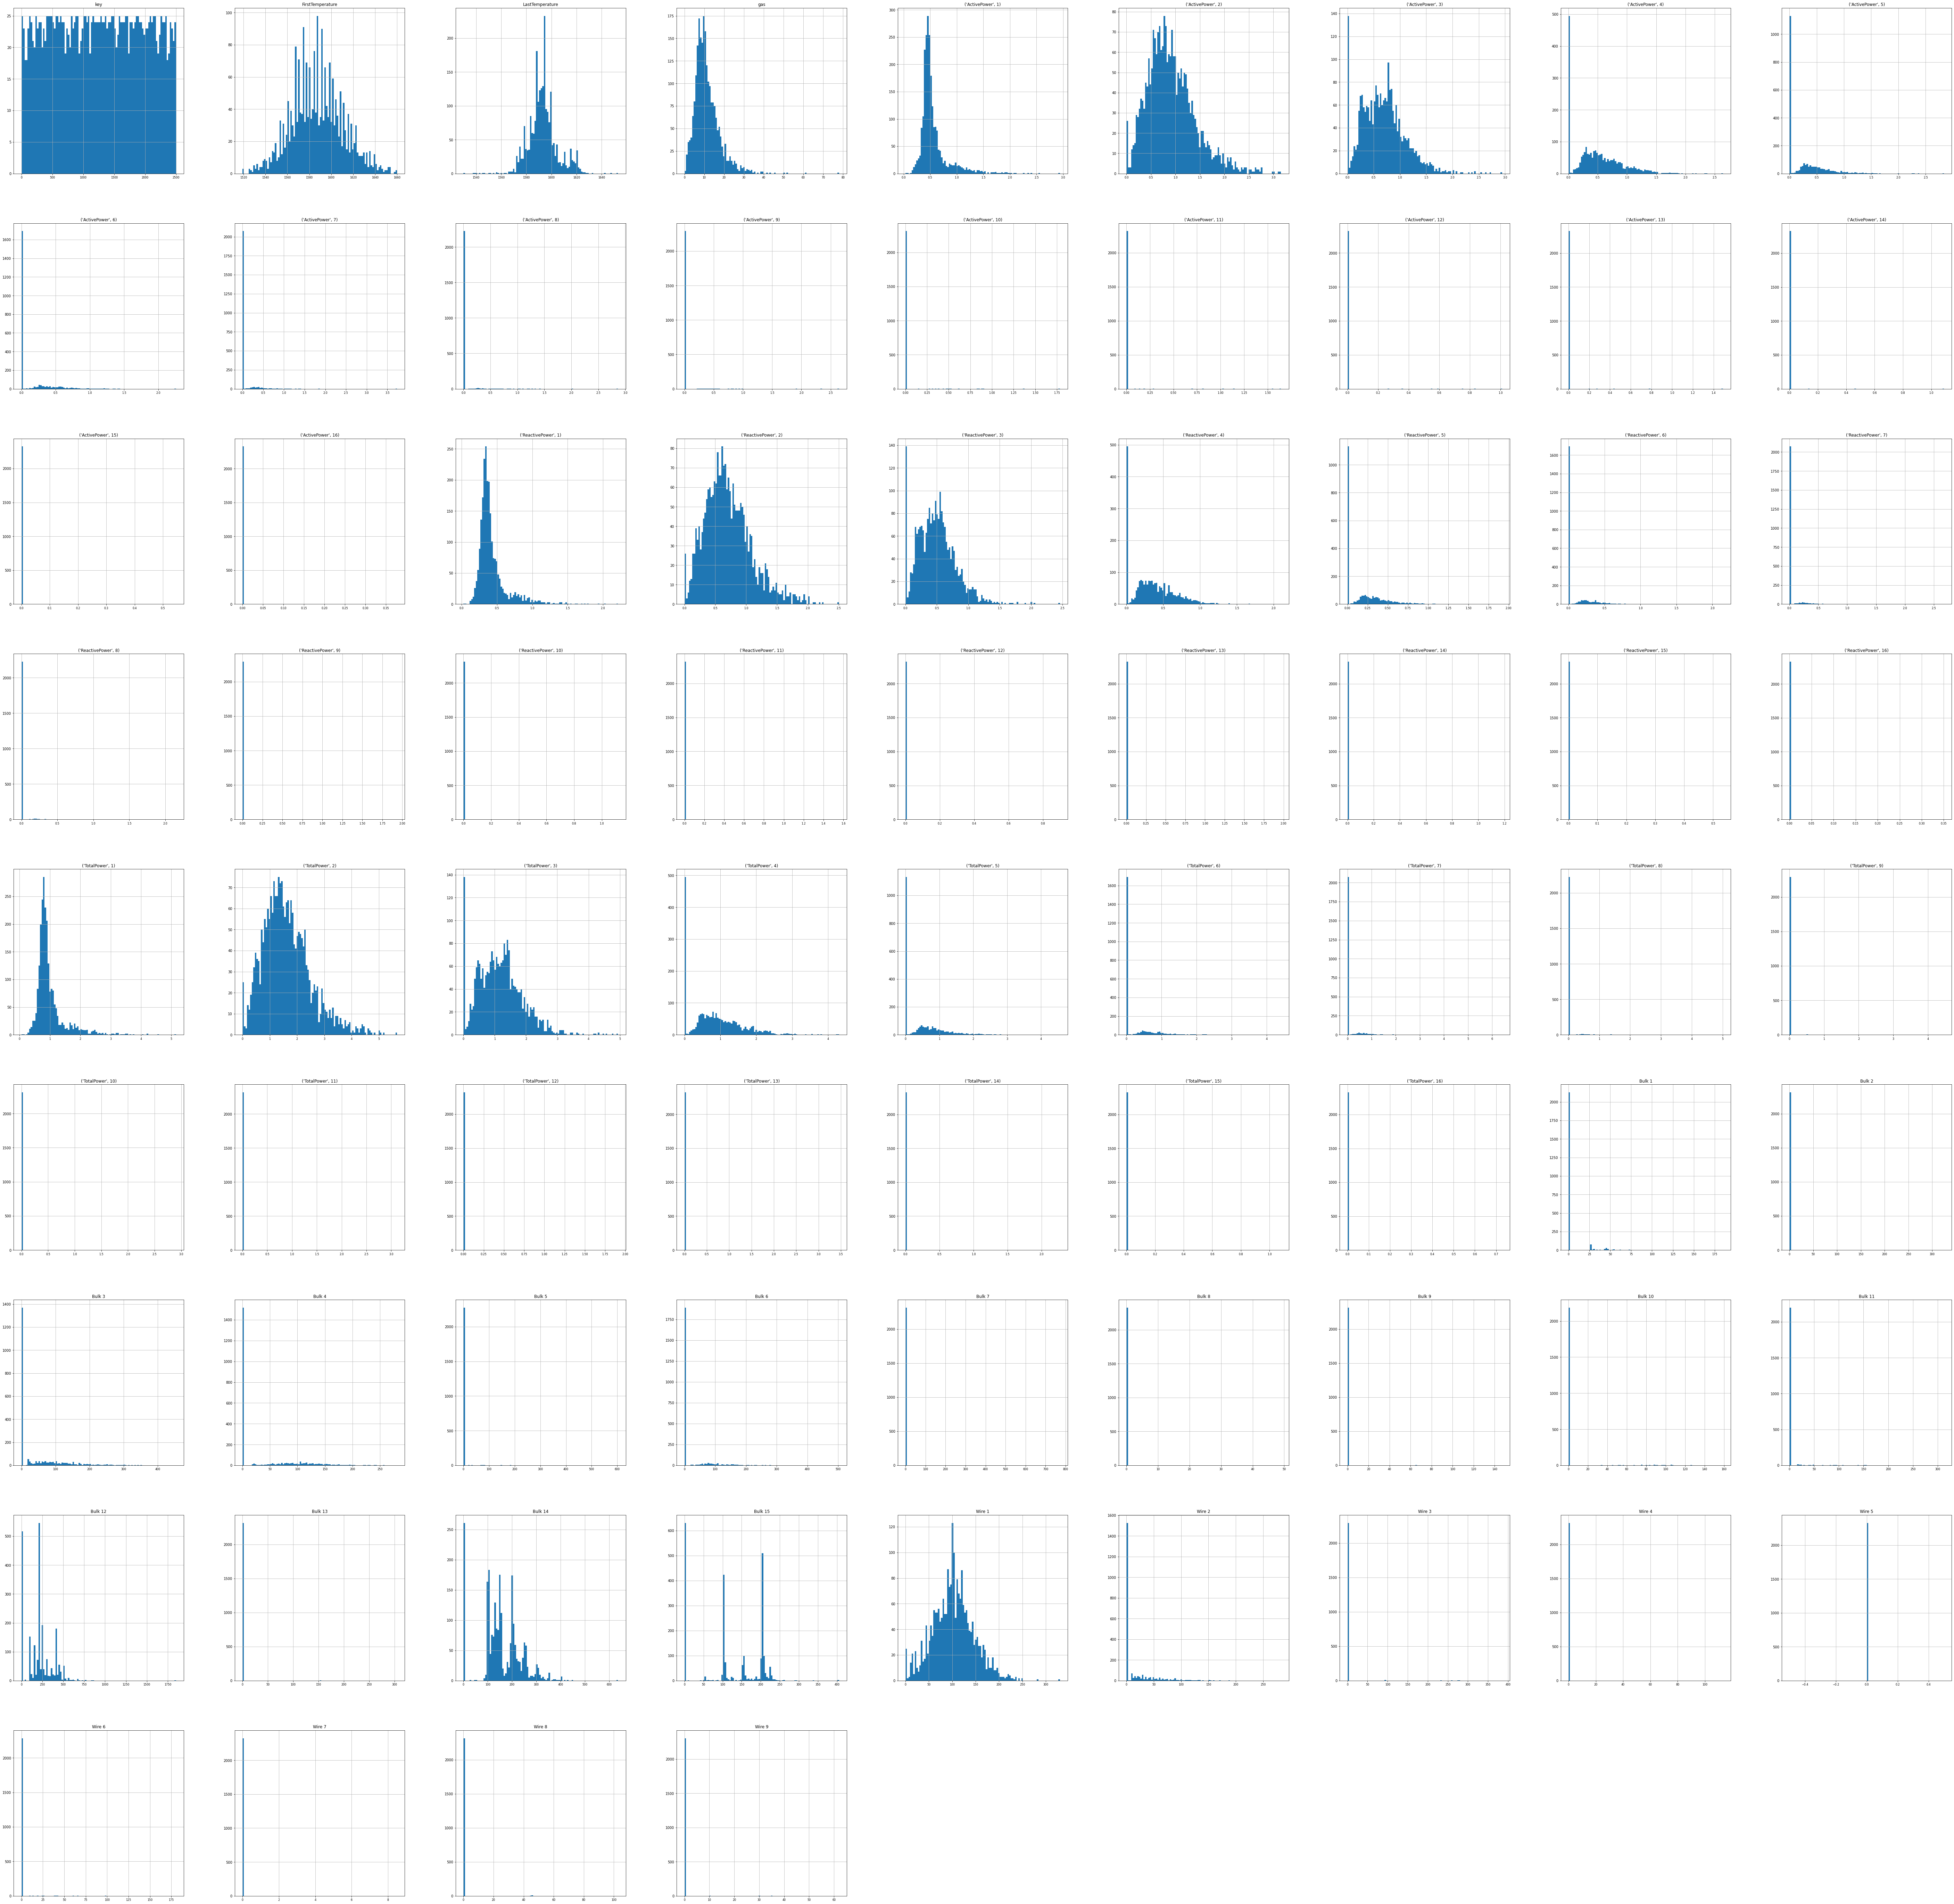

In [97]:
data_all.hist(figsize=(100, 100), bins=100, xlabelsize=8)

In [98]:
correlation_matrix = data_all.corr()

print(correlation_matrix['LastTemperature'].sort_values(ascending=False))


LastTemperature     1.000000
FirstTemperature    0.306398
Wire 1              0.301681
Bulk 12             0.254198
Bulk 15             0.251541
                      ...   
Wire 7             -0.133630
Wire 4             -0.154977
Bulk 6             -0.174148
Wire 2             -0.196253
Wire 5                   NaN
Name: LastTemperature, Length: 76, dtype: float64


In [99]:
for col, value in correlation_matrix['LastTemperature'].items():
    print(f"Correlation with {col}: {value}")


Correlation with key: -0.08976483875286406
Correlation with FirstTemperature: 0.306398085198678
Correlation with LastTemperature: 1.0
Correlation with gas: 0.06025428997959696
Correlation with ('ActivePower', 1): 0.0016874863736298666
Correlation with ('ActivePower', 2): 0.15826051860168924
Correlation with ('ActivePower', 3): 0.17281097546538607
Correlation with ('ActivePower', 4): 0.1856411132844248
Correlation with ('ActivePower', 5): 0.17190171033704463
Correlation with ('ActivePower', 6): 0.18513853962959054
Correlation with ('ActivePower', 7): 0.12230183597186486
Correlation with ('ActivePower', 8): 0.07765892730367388
Correlation with ('ActivePower', 9): 0.028479454244497868
Correlation with ('ActivePower', 10): -0.014415032777287349
Correlation with ('ActivePower', 11): -0.06417771603852708
Correlation with ('ActivePower', 12): -0.036214039871135334
Correlation with ('ActivePower', 13): -0.08577055367722283
Correlation with ('ActivePower', 14): -0.033261322899913535
Correlation

### Сформирован консолидированный датасет. Основой была взята таблица о температуре партий металла. Одно наблюдение соответствует одной партии металла. Выполнена оценка корреляции признаков с целевым. Наибольшее значение имеет начальная температура сплава, затем разнонаправленная корреляция с объёмами добавок к сплаву на разных технологических этапах.

## Подготовка данных для обучения

In [100]:
data_all.columns = [str(col) for col in data_all.columns]

In [101]:
X = data_all.drop(['LastTemperature'], axis=1)
y = data_all['LastTemperature']

In [102]:
X

,key,FirstTemperature,gas,"('ActivePower', 1)","('ActivePower', 2)","('ActivePower', 3)","('ActivePower', 4)","('ActivePower', 5)","('ActivePower', 6)","('ActivePower', 7)",...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,29.749986,0.976059,0.805607,0.744363,1.659363,0.692755,0.0000,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,12.555561,0.438063,1.296415,0.490377,0.827743,0.000000,0.0000,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,28.554793,1.062053,0.484206,0.429355,0.299989,0.250280,0.0000,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,18.841219,0.875313,0.425692,0.687289,1.220955,0.000000,0.0000,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,5.413692,0.950026,0.508026,1.621665,0.267457,0.000000,0.0000,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,7.125735,0.875021,1.062164,0.838270,0.435236,0.000000,0.0000,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,1554.0,9.412616,0.393625,0.687349,1.006370,0.509225,0.556695,1.0498,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,1571.0,6.271699,0.580983,0.834539,0.796857,0.000000,0.000000,0.0000,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,1591.0,14.953657,1.162895,0.598447,0.574522,0.892648,0.180213,0.0000,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1746, 75)

(583, 75)

(1746,)

(583,)

In [104]:
X_train_copy = X_train.copy() 
y_train_copy = y_train.copy()

In [105]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [106]:
X_train

array([[ 0.94986706, -0.12301708, -0.12106917, ..., -0.02939889,
        -0.05962962, -0.08596029],
       [-1.53364958,  0.51852361, -0.45878803, ..., -0.02939889,
        -0.05962962, -0.08596029],
       [-0.69326769,  2.22929881, -0.55005856, ..., -0.02939889,
        -0.05962962, -0.08596029],
       ...,
       [ 0.63211072, -0.33686398, -0.78842465, ..., -0.02939889,
        -0.05962962, -0.08596029],
       [ 1.50733432,  0.47575424, -0.34691025, ..., -0.02939889,
        -0.05962962, -0.08596029],
       [ 1.31640178, -2.00486979,  0.27090963, ..., -0.02939889,
        -0.05962962, -0.08596029]])

## Подбор параметров и обучение моделей

In [107]:
model_1 = RandomForestRegressor(random_state=RANDOM_STATE)
params_1 = {'n_estimators': range (10, 200, 10), 'max_depth': range(1, 12, 2)}
search_1 = GridSearchCV(model_1, params_1, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
search_1.fit(X_train, y_train)
best_model_1 = search_1.best_estimator_
print(search_1.best_params_)
print(search_1.best_score_ * -1)

{'max_depth': 11, 'n_estimators': 170}
6.4652863872861746


In [108]:
model_2 = LGBMRegressor()
params_2 = {'n_estimators': range(100, 250, 50), 'max_depth': range(3, 13, 2), 'learning_rate': [0.01, 0.05, 0.1]}
search_2 = GridSearchCV(model_2, params_2, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
search_2.fit(X_train, y_train)
best_model_2 = search_2.best_estimator_
print(search_2.best_params_)
print(search_2.best_score_ * -1)

{'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 200}
6.1570938401183035


In [109]:
model_3 = CatBoostRegressor(loss_function='MAE', learning_rate=0.05)
params_3 = {'iterations': [100, 500, 1000], 'depth': [4, 6, 8]}
search_3 = GridSearchCV(model_3, params_3, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
search_3.fit(X_train, y_train)
best_model_3 = search_3.best_estimator_
print(search_3.best_params_)
print(search_3.best_score_ * -1)

0:	learn: 8.0203428	total: 51.4ms	remaining: 5.09s
1:	learn: 7.9749990	total: 55ms	remaining: 2.69s
2:	learn: 7.9181793	total: 58.2ms	remaining: 1.88s
3:	learn: 7.8611956	total: 61.6ms	remaining: 1.48s
4:	learn: 7.8149055	total: 64.7ms	remaining: 1.23s
5:	learn: 7.7682406	total: 67.9ms	remaining: 1.06s
6:	learn: 7.7146282	total: 71ms	remaining: 943ms
7:	learn: 7.6838018	total: 74.2ms	remaining: 853ms
8:	learn: 7.6406900	total: 77.5ms	remaining: 784ms
9:	learn: 7.5940134	total: 80.8ms	remaining: 727ms
10:	learn: 7.5466215	total: 84ms	remaining: 680ms
11:	learn: 7.4943057	total: 87.2ms	remaining: 640ms
12:	learn: 7.4541986	total: 90.7ms	remaining: 607ms
13:	learn: 7.4033774	total: 94.1ms	remaining: 578ms
14:	learn: 7.3529810	total: 97.5ms	remaining: 552ms
15:	learn: 7.3206615	total: 101ms	remaining: 529ms
16:	learn: 7.3007434	total: 104ms	remaining: 508ms
17:	learn: 7.2560433	total: 107ms	remaining: 489ms
18:	learn: 7.2214416	total: 111ms	remaining: 471ms
19:	learn: 7.1894966	total: 114m

In [110]:
model_4 = Sequential()

model_4.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))
model_4.add(Dense(214, activation='relu'))
model_4.add(Dense(214, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))
model_4.add(Dense(428, activation='relu'))
model_4.add(Dense(107, activation='relu'))
model_4.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.01)

model_4.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

2023-11-28 20:04:42.088475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [111]:
model_4.fit(
    X_train, y_train, epochs=150,
    verbose=2, shuffle=True
    )

Epoch 1/150
55/55 - 2s - loss: 418866.4062 - mae: 455.5180 - 2s/epoch - 28ms/step
Epoch 2/150
55/55 - 1s - loss: 41333.9609 - mae: 162.9651 - 682ms/epoch - 12ms/step
Epoch 3/150
55/55 - 1s - loss: 50839.2422 - mae: 181.2836 - 605ms/epoch - 11ms/step
Epoch 4/150
55/55 - 1s - loss: 36605.7812 - mae: 154.1010 - 594ms/epoch - 11ms/step
Epoch 5/150
55/55 - 1s - loss: 32621.4434 - mae: 145.1519 - 604ms/epoch - 11ms/step
Epoch 6/150
55/55 - 1s - loss: 18171.0176 - mae: 106.2385 - 602ms/epoch - 11ms/step
Epoch 7/150
55/55 - 1s - loss: 12954.1650 - mae: 88.5886 - 591ms/epoch - 11ms/step
Epoch 8/150
55/55 - 1s - loss: 10935.0215 - mae: 82.2777 - 600ms/epoch - 11ms/step
Epoch 9/150
55/55 - 1s - loss: 10181.0127 - mae: 80.1040 - 599ms/epoch - 11ms/step
Epoch 10/150
55/55 - 1s - loss: 11273.3359 - mae: 82.9802 - 603ms/epoch - 11ms/step
Epoch 11/150
55/55 - 1s - loss: 12221.0947 - mae: 86.9015 - 601ms/epoch - 11ms/step
Epoch 12/150
55/55 - 1s - loss: 8118.9263 - mae: 71.2657 - 591ms/epoch - 11ms/ste

## Предварительный вывод №2

Были обучены и проверены 4 модели:RandomForestRegressor(), LGBMRegressor(), CatBoostRegressor() и полносвязная нейронная сеть с 8 скрытыми слоями. Оценивалась метрика качества MAE. Лучший результат показала модель CatBoostRegressor() = 6.0981821562622285

## Проверка качества лучшей модели на тестовой выборке

In [112]:
predict_test = best_model_3.predict(X_test)
print(mean_absolute_error(y_test, predict_test))
print(r2_score(y_test, predict_test))

6.226704415651851
0.3841015401814216


In [113]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
predict_dum = dummy_regr.predict(X_test)
print(mean_absolute_error(y_test, predict_dum))
print(r2_score(y_test, predict_dum))

8.2792611978568
-0.0057822626227861385


## Предварительный вывод №3

Модель CatBoostRegressor(), показавшая лучший результат была протестированая на отложенной выборке. Были получены следующие результаты: MAE = 6.226704415651851 и коэффициент детерминации = 0.3841015401814216. Т.е. модель недостаточно соответствует обрабатываемым данным, но качество модели удовлетворяет требованиям заказчика (MAE<6.8). Константная модель показала MAE = 8.2792611978568 и коэффициент детерминации стремящийся к 0.

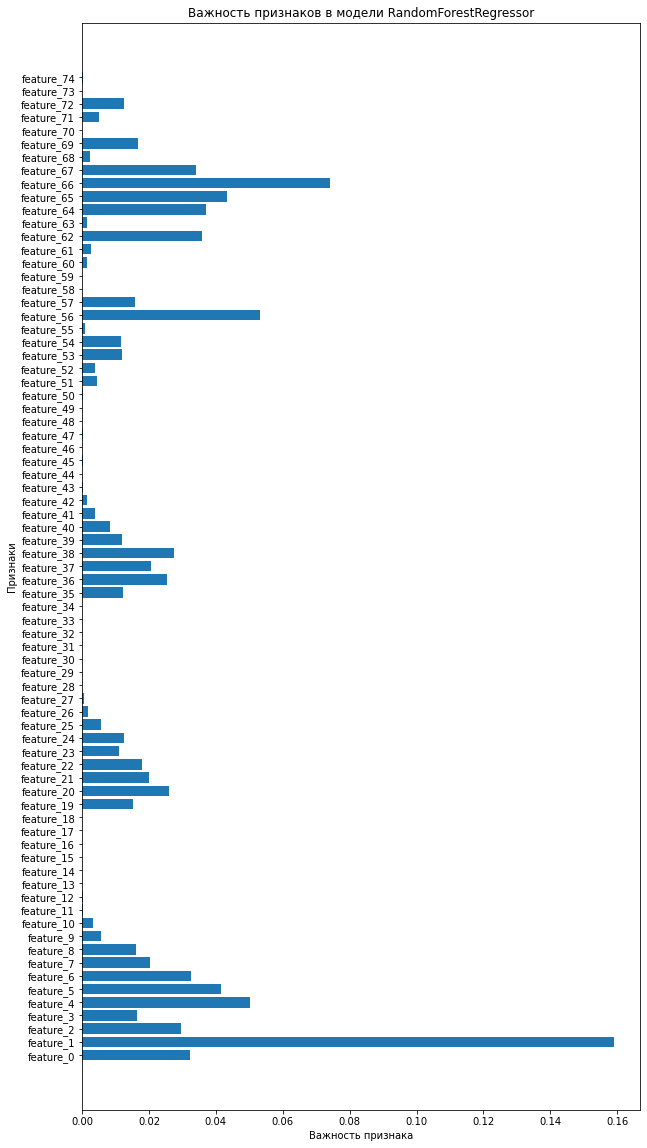

In [114]:
feature_importance = best_model_1.feature_importances_
feature_names = list(X_train.columns) if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 20))
plt.barh(feature_names, feature_importance)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели RandomForestRegressor')
plt.show()

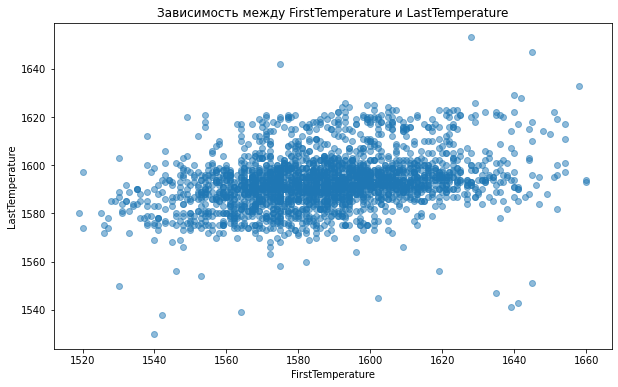

In [115]:
plt.figure(figsize=(10, 6))
plt.scatter(data_all['FirstTemperature'], data_all['LastTemperature'], alpha=0.5)
plt.title('Зависимость между FirstTemperature и LastTemperature')
plt.xlabel('FirstTemperature')
plt.ylabel('LastTemperature')
plt.show()

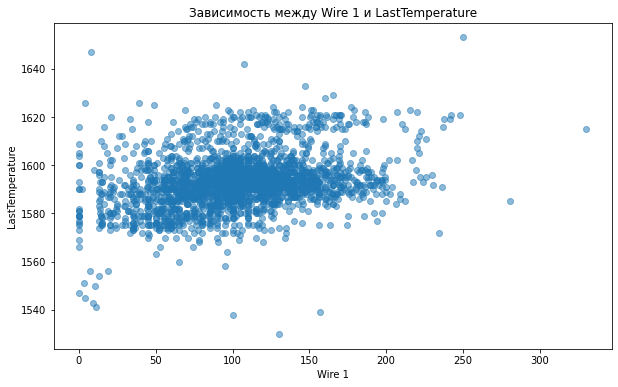

In [116]:
plt.figure(figsize=(10, 6))
plt.scatter(data_all['Wire 1'], data_all['LastTemperature'], alpha=0.5)
plt.title('Зависимость между Wire 1 и LastTemperature')
plt.xlabel('Wire 1')
plt.ylabel('LastTemperature')
plt.show()

# Общий вывод

Была поставлена задача подбора и обучения модели предсказания температуры сплава в цикле металлургического производства. Были представлены данные о температуре, количественные данные о технологических этапах производства (энергозатраты, масса и объём добавок в сплав). Целевой признак для моделей: конечная температура партии металла. 
Были обучены с подбором параметров 4 модели: RandomForestRegressor(), LGBMRegressor(), CatBoostRegressor() и полносвязная нейронная сеть с 8 скрытыми слоями. Оценивалась метрика качества MAE. Лучший результат показала модель CatBoostRegressor() = 6.0981821562622285. Обученная модель была протестирована на отложенной выборке. Были получены следующие результаты: MAE = 6.226704415651851 и коэффициент детерминации = 0.3841015401814216. Т.е. модель недостаточно соответствует обрабатываемым данным, но качество модели удовлетворяет требованиям заказчика (MAE<6.8).
Наибольшее значение для целевого признака имеют 2 показателя: начальная температура сплава и масса добавленных проволочных материалов (вероятно, добавки, повышающие температуру плавления сплава). 

Примечание. 
По условиям задания представленные данные о времени измерения температуры, времени внесения добавок и других технологических точек не рассматриваются как данные для постороения времянных рядов, поэтому они не используются в обучении моделей. Как суррогат привязки технологических этапов к течению времени технологического цикла можно считать дробное введение добавок, нагрева сплава и пр. Для дальнейшего улучшения качества модели необходимо ввести в тренировочный датасет признаки, связанные с хронологией технологического цикла.